# Nutritional Inequality and Food Prices  

## Introduction  

Nutritional inequality refers to disparities in diet quality and access to healthy food across different socioeconomic groups. Rising food prices, food deserts, and lack of nutrition education contribute to this issue, affecting millions of Americans. As of 2025, **around 40 million Americans** experience food insecurity, with many turning to cheaper, less nutritious options due to affordability and accessibility challenges.  

In this project, we explore **how food prices impact dietary choices and accessibility across different regions and income levels**. Our research focuses on:  

- **Comparing** the cost of nutrient-dense foods (fruits, vegetables) versus processed foods  
- **Analyzing** geographical disparities in food availability (food deserts)  
- **Investigating** the role of socioeconomic factors in nutritional choices  
- **Assessing** the impact of nutrition education on food access and consumption  

To address these questions, we leverage publicly available datasets from **USDA, BLS, FAO, and Kaggle**, integrating statistical analysis and visualization techniques. Our goal is to uncover meaningful insights into the systemic causes of nutritional inequality and potential policy interventions.  

---  
### Notebook Workflow  
🔹 **Data Wrangling:** Cleaning and preprocessing datasets  
🔹 **Combining Data:** Merging multiple sources for comprehensive analysis  
🔹 **Statistical Analysis:** Identifying correlations between food prices, income, and access  
🔹 **Visualization:** Presenting trends and disparities through charts and maps  

This notebook serves as a prototype for our analysis, demonstrating key data transformations, exploratory statistics, and preliminary findings. 🚀  

In [2]:
# Load in packages

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# others

In [ ]:
# Load in datasets
folder_path = 'project data/'

historical_changes_consumer_price = pd.read_csv(folder_path + '(historical) changes_consumer_price.csv')
historical_producer_price_changes = pd.read_csv(folder_path + '(historical) producer_price_changes.csv')
consumer_price = pd.read_csv(folder_path + 'changes_consumer_price_indices.csv')
producer_price = pd.read_csv(folder_path + 'changes_producer_price.csv')
state_and_county = pd.read_csv(folder_path + 'StateAndCountyData.csv')
variable_list = pd.read_csv(folder_path + 'VariableList.csv')

## Data Wrangling 

### For CPI + PPI 

In [ ]:
historical_producer_price_changes.head()

,Producer Price Index item,Year,Percent change,Category
0,Unprocessed foodstuffs and feedstuffs,1974,5.2,Processed
1,Unprocessed foodstuffs and feedstuffs,1975,1.3,Processed
2,Unprocessed foodstuffs and feedstuffs,1976,-0.8,Processed
3,Unprocessed foodstuffs and feedstuffs,1977,0.9,Processed
4,Unprocessed foodstuffs and feedstuffs,1978,12.6,Processed


In [7]:
## Showing data
historical_changes_consumer_price.head()

,Consumer Price Index item,Year,Percent change
0,All food,1974,14.3
1,All food,1975,8.5
2,All food,1976,3.0
3,All food,1977,6.3
4,All food,1978,9.9


In [14]:
# cleaning historical producer price changes + consumer price 

historical_producer_price_changes['Year'] = pd.to_numeric(historical_producer_price_changes['Year'], errors='coerce')
historical_producer_price_changes['Percent change'] = pd.to_numeric(historical_producer_price_changes['Percent change'], errors='coerce')
historical_changes_consumer_price['Year'] = pd.to_numeric(historical_changes_consumer_price['Year'], errors='coerce')
historical_changes_consumer_price['Percent change'] = pd.to_numeric(historical_changes_consumer_price['Percent change'], errors='coerce')

historical_producer_price_changes = historical_producer_price_changes.dropna()
historical_changes_consumer_price = historical_changes_consumer_price.dropna()

def categorize_food(item):
    item = item.lower()
    if "farm-level" in item:
        return "Farm Level"
    elif "wholesale" in item:
        return "Wholesale"
    elif "processed" in item:
        return "Processed"
    elif "unprocessed" in item:
        return "Unprocessed"
    elif "finished" in item:
        return "Finished"
    else:
        return "Other"

# create new category 
historical_producer_price_changes['Category'] = historical_producer_price_changes['Producer Price Index item'].apply(categorize_food)

print(historical_changes_consumer_price['Consumer Price Index item'].unique())

print(historical_producer_price_changes['Producer Price Index item'].unique())

# creating map as categories differ 
mapping = {
    "Wholesale beef": "Beef and veal",
    "Farm-level cattle": "Beef and veal",
    "Wholesale pork": "Pork",
    "Wholesale poultry": "Poultry",
    "Farm-level eggs": "Eggs",
    "Wholesale dairy": "Dairy products",
    "Farm-level milk": "Dairy products",
    "Farm-level soybeans": "Fats and oils",
    "Wholesale fats and oils": "Fats and oils",
    "Farm-level fruit": "Fresh fruits",
    "Farm-level vegetables": "Fresh vegetables",
    "Farm-level wheat": "Cereals and bakery products",
    "Wholesale wheat flour": "Cereals and bakery products",
    "Unprocessed foodstuffs and feedstuffs": "All food",
    "Processed foods and feeds": "All food",
    "Finished consumer foods": "All food",
}

historical_producer_price_changes['Mapped Category'] = historical_producer_price_changes['Producer Price Index item'].map(mapping)

# merge data set 

cpi_ppi = pd.merge(
    historical_changes_consumer_price,
    historical_producer_price_changes,
    left_on=['Year', 'Consumer Price Index item'],
    right_on=['Year', 'Mapped Category'],
    suffixes=('_consumer', '_producer')
)

# remove columns 

cpi_ppi = cpi_ppi.drop(columns=['Producer Price Index item', 'Mapped Category'])
cpi_ppi = cpi_ppi.dropna()

# display 

print(cpi_ppi.head())

['All food' 'Food away from home' 'Food at home'
 'Meats, poultry, and fish' 'Meats' 'Beef and veal' 'Pork' 'Other meats'
 'Poultry' 'Fish and seafood' 'Eggs' 'Dairy products' 'Fats and oils'
 'Fruits and vegetables' 'Fresh fruits and vegetables' 'Fresh fruits'
 'Fresh vegetables' 'Processed fruits and vegetables' 'Sugar and sweets'
 'Cereals and bakery products' 'Nonalcoholic beverages' 'Other foods']
['Unprocessed foodstuffs and feedstuffs' 'Processed foods and feeds'
 'Finished consumer foods' 'Farm-level cattle' 'Wholesale beef'
 'Wholesale pork' 'Wholesale poultry' 'Farm-level eggs' 'Farm-level milk'
 'Wholesale dairy' 'Farm-level soybeans' 'Wholesale fats and oils'
 'Farm-level fruit' 'Farm-level vegetables' 'Farm-level wheat'
 'Wholesale wheat flour']
  Consumer Price Index item  Year  Percent change_consumer  \
0                  All food  1974                     14.3   
1                  All food  1974                     14.3   
2                  All food  1974            

### Stat + County Data Set

In [16]:
## Variable list
variable_list.head()

,Variable_Name,Category_Name,Category_Code,Subcategory_Name,Variable_Code,Geography,Units
0,"Population, low access to store, 2010",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP10,CNTY10,Count
1,"Population, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP15,CNTY10,Count
2,"Population, low access to store (% change), 20...",Access and Proximity to Grocery Store,ACCESS,Overall,PCH_LACCESS_POP_10_15,CNTY10,% change
3,"Population, low access to store (%), 2010",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP10,CNTY10,Percent
4,"Population, low access to store (%), 2015",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP15,CNTY10,Percent


In [ ]:
## State + County Data set 
state_and_county.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga,LACCESS_POP10,18428.439690
1,1001,AL,Autauga,LACCESS_POP15,17496.693040
2,1001,AL,Autauga,PCH_LACCESS_POP_10_15,-5.056026
3,1001,AL,Autauga,PCT_LACCESS_POP10,33.769657
4,1001,AL,Autauga,PCT_LACCESS_POP15,32.062255


## Combining Data

In [14]:
## combine data

## Statistical Analysis

In [16]:
## hypothesis test

## Visualization

Producer Data Summary:
               Producer Price Index item  Year  Percent change   Category
0  Unprocessed foodstuffs and feedstuffs  1974             5.2  Processed
1  Unprocessed foodstuffs and feedstuffs  1975             1.3  Processed
2  Unprocessed foodstuffs and feedstuffs  1976            -0.8  Processed
3  Unprocessed foodstuffs and feedstuffs  1977             0.9  Processed
4  Unprocessed foodstuffs and feedstuffs  1978            12.6  Processed


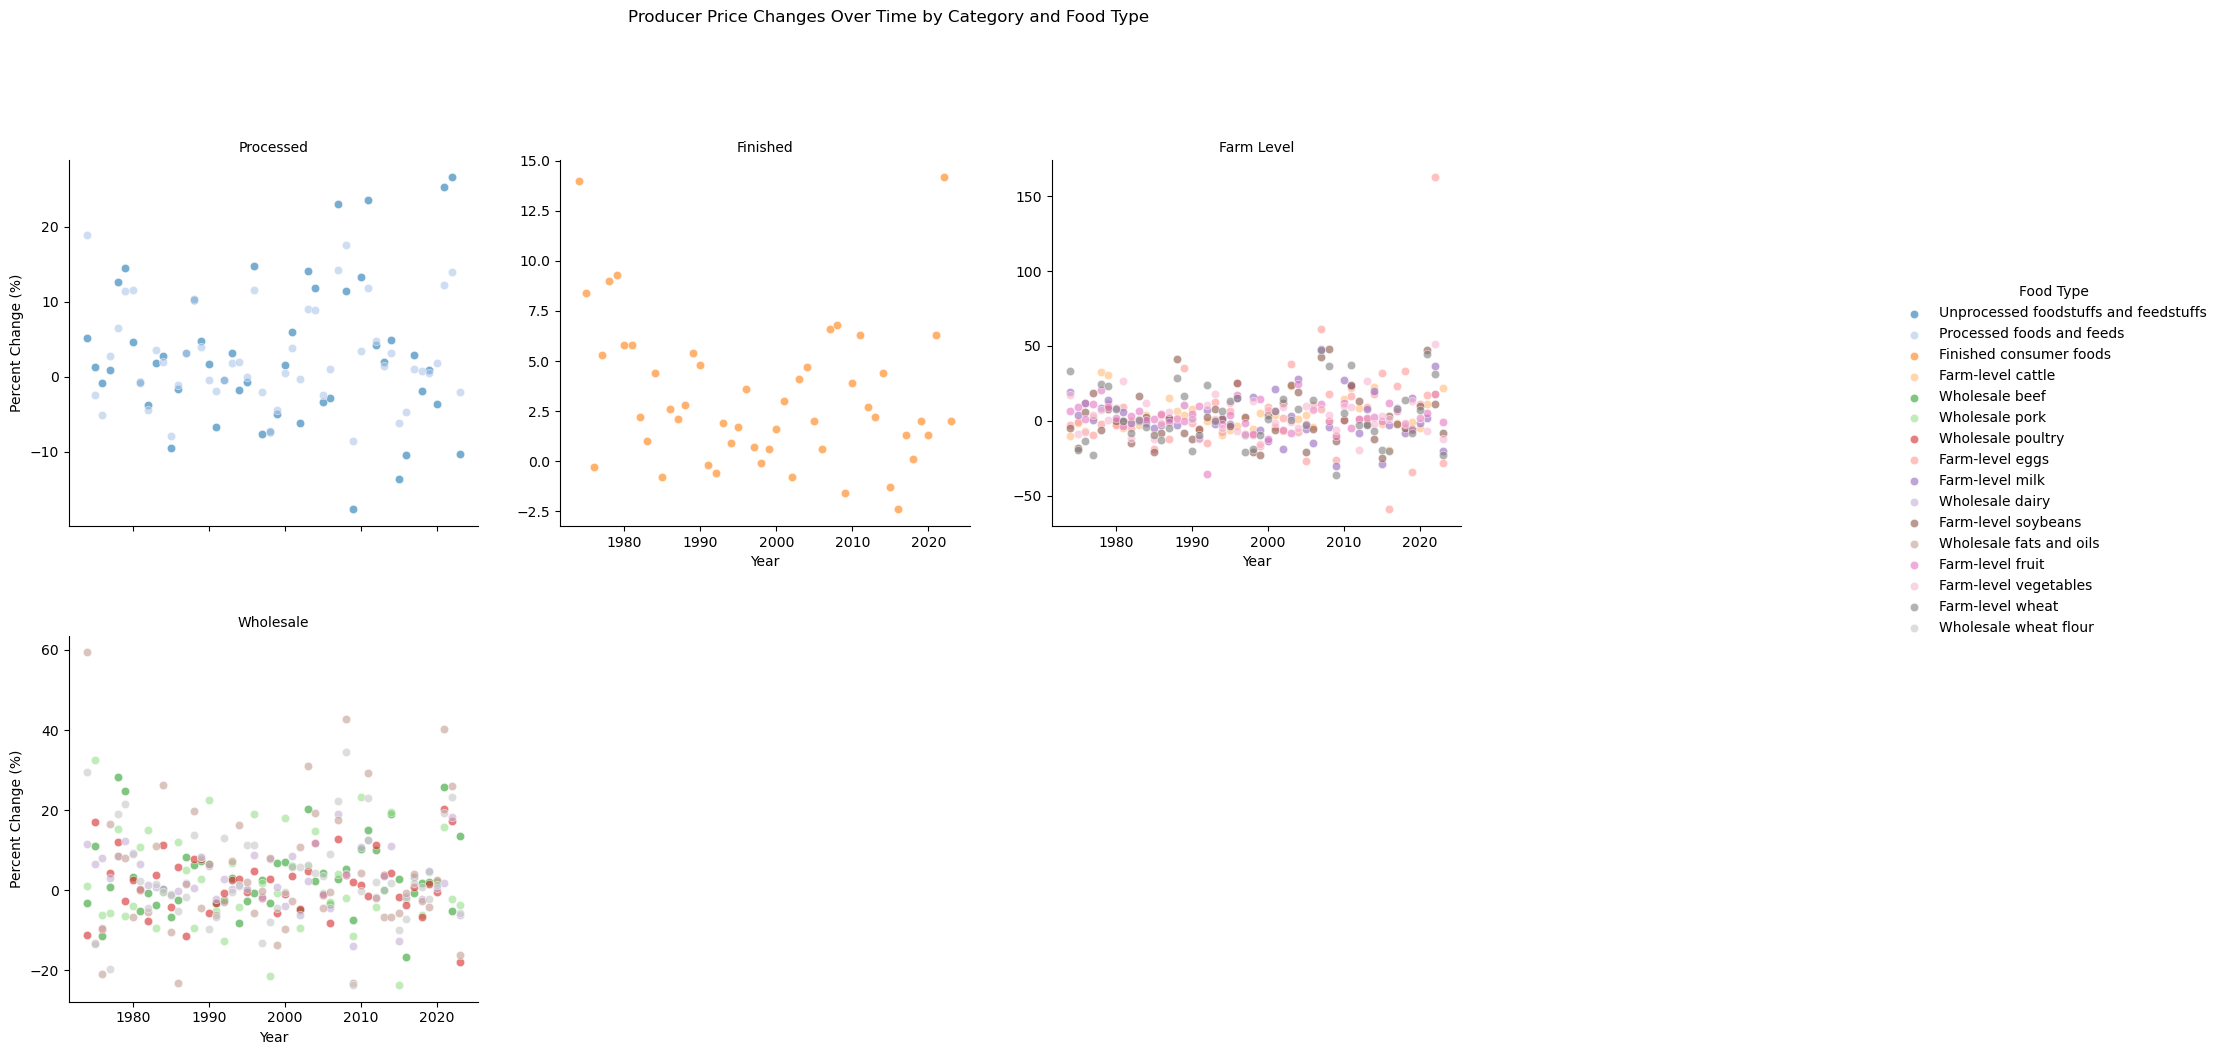

In [18]:
print("Producer Data Summary:")
print(historical_producer_price_changes.head())

# scatterplot faceted 
g = sns.FacetGrid(
    historical_producer_price_changes,
    col="Category",
    col_wrap=3,
    height=5,
    sharey=False,
    hue="Producer Price Index item",
    palette="tab20",
)

# scatter + line 
g.map_dataframe(
    sns.scatterplot,
    x="Year",
    y="Percent change",
    alpha=0.6,  
)

# legend + title 
g.add_legend(title="Food Type", bbox_to_anchor=(1.05, 0.6), loc='center left')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Percent Change (%)")
g.fig.suptitle("Producer Price Changes Over Time by Category and Food Type", y=1.05)

# layout 
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.2)
plt.show()

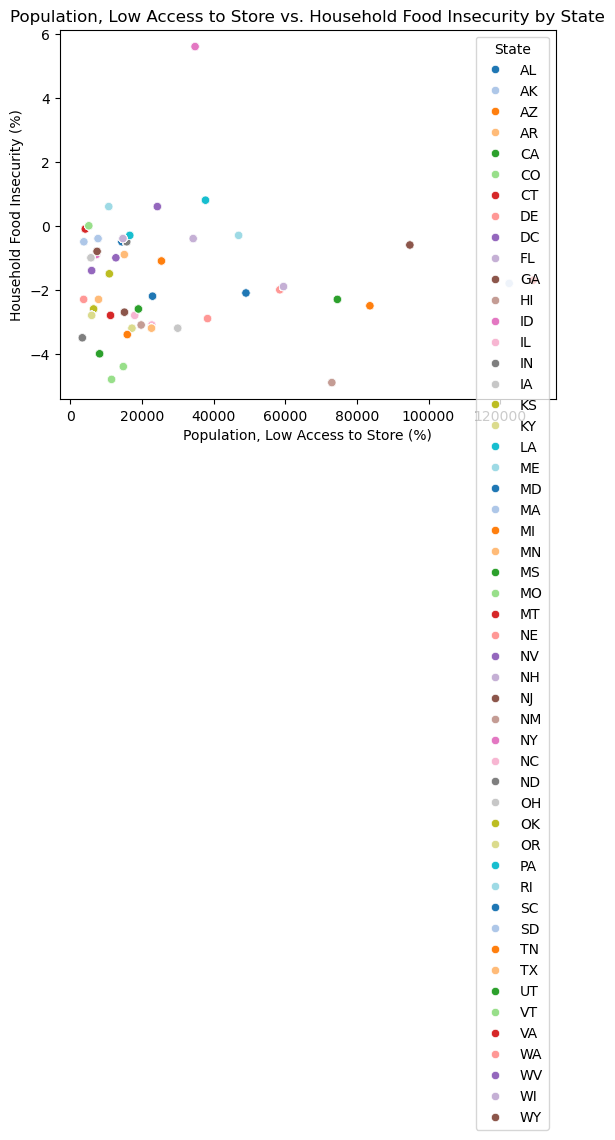

In [19]:
# Household food insecurity (%, three-year average), 2015-17 -- vs -- Population, low access to store, 2015

# Filter low access population data
filtered_data_low_access = state_and_county[state_and_county['Variable_Code'] == 'LACCESS_POP15'].copy()
filtered_data_low_access['Low Access Population'] = pd.to_numeric(filtered_data_low_access['Value'], errors='coerce')

state_avg_low_access = filtered_data_low_access.groupby('State')['Low Access Population'].mean().reset_index()

# Filter household insecurity data
filtered_data_insecurity = state_and_county[state_and_county['Variable_Code'] == 'CH_FOODINSEC_14_17'][['State', 'Value']].copy()
filtered_data_insecurity.rename(columns={'Value': 'Household Insecurity'}, inplace=True)
filtered_data_insecurity['Household Insecurity'] = pd.to_numeric(filtered_data_insecurity['Household Insecurity'], errors='coerce')

# Merge the two datasets on FIPS code to align counties correctly
merged_data = filtered_data_insecurity.merge(state_avg_low_access, on='State', how='left')

# # Create scatter plot
sns.scatterplot(
    data=merged_data,
    x='Low Access Population',
    y='Household Insecurity',
    hue='State',
    palette='tab20',
)

plt.title("Population, Low Access to Store vs. Household Food Insecurity by State")
plt.xlabel("Population, Low Access to Store (%)")
plt.ylabel("Household Food Insecurity (%)")

plt.show()
